<a href="https://colab.research.google.com/github/drbaijsingh/baijsingh/blob/main/CMAPSS_FD004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import pandas as pd
import numpy as np

columns = (
    ['engine_id', 'cycle'] +
    [f'op_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)

train_df = pd.read_csv(
    '/content/train_FD004.txt',
    delim_whitespace=True,
    header=None,
    names=columns
)

train_df.head()


/tmp/ipython-input-1491662722.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(


,engine_id,cycle,op_1,op_2,op_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [3]:
print("Shape:", train_df.shape)
print("Engines:", train_df.engine_id.nunique())


Shape: (61249, 26)
Engines: 249


In [4]:
train_df[['engine_id','cycle']].tail()

,engine_id,cycle
61244,249,251
61245,249,252
61246,249,253
61247,249,254
61248,249,255


In [5]:
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = train_df['engine_id'].map(max_cycle) - train_df['cycle']


In [6]:
train_df.groupby('engine_id')['RUL'].agg(['min','max']).head()


,min,max
engine_id,,
1,0,320
2,0,298
3,0,306
4,0,273
5,0,192


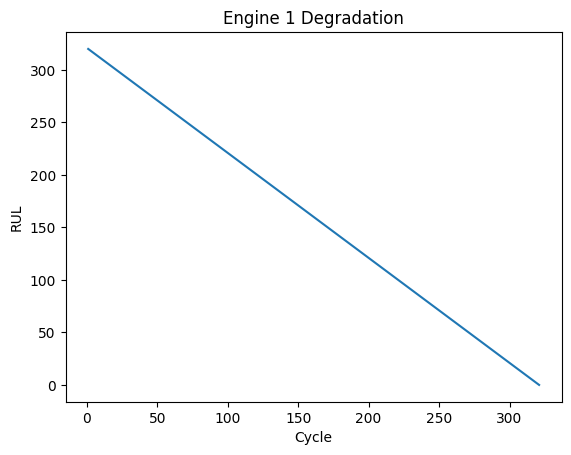

In [7]:
import matplotlib.pyplot as plt

e1 = train_df[train_df.engine_id == 1]

plt.figure()
plt.plot(e1['cycle'], e1['RUL'])
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title("Engine 1 Degradation")
plt.show()


In [8]:
train_df.drop(columns=['op_1','op_2','op_3'], inplace=True)


In [9]:
features = [
    'sensor_2','sensor_3','sensor_4','sensor_7',
    'sensor_8','sensor_9','sensor_11','sensor_12',
    'sensor_13','sensor_14','sensor_15',
    'sensor_17','sensor_20','sensor_21'
]


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])


In [11]:
def create_sequences(df, seq_len, feature_cols):
    X, y = [], []

    for eid in df.engine_id.unique():
        edf = df[df.engine_id == eid].reset_index(drop=True)

        for i in range(len(edf) - seq_len):
            X.append(edf.loc[i:i+seq_len-1, feature_cols].values)
            y.append(edf.loc[i+seq_len, 'RUL'])

    return np.array(X), np.array(y)


In [12]:
SEQ_LEN = 30
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

print(X_train.shape)
print(y_train.shape)

(53779, 30, 14)
(53779,)


In [13]:
# Recompute RUL cleanly
max_cycle = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = max_cycle[train_df.engine_id].values - train_df.cycle

# Cap RUL
train_df['RUL'] = train_df['RUL'].clip(upper=125)

# Recreate sequences
X_train, y_train = create_sequences(train_df, SEQ_LEN, features)

In [14]:
RUL_CAP = 125
train_df['RUL'] = train_df['RUL'].clip(upper=RUL_CAP)




In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LEN, len(features))),
    Dropout(0.3),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


In [21]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)



Epoch 1/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 6861.6577 - mae: 72.9952 - val_loss: 3858.6545 - val_mae: 54.5240
Epoch 2/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3405.2380 - mae: 51.6248 - val_loss: 2277.1191 - val_mae: 43.3148
Epoch 3/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2119.4814 - mae: 41.9495 - val_loss: 1811.9154 - val_mae: 38.7387
Epoch 4/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1773.4197 - mae: 38.1986 - val_loss: 1739.3235 - val_mae: 37.2460
Epoch 5/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1721.7145 - mae: 37.0243 - val_loss: 1736.8046 - val_mae: 36.8906
Epoch 6/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1722.6281 - mae: 36.7734 - val_loss: 1737.3633 - val_mae: 36.8235
Epoch 7/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1713.1493 - mae: 36.6193 - val_loss: 1737.3691 - val_mae: 36.8229
Epoch 8/40
673/673 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1711.0514 - mae: 36.5589 - val_loss: 1738.6959 - val_mae:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


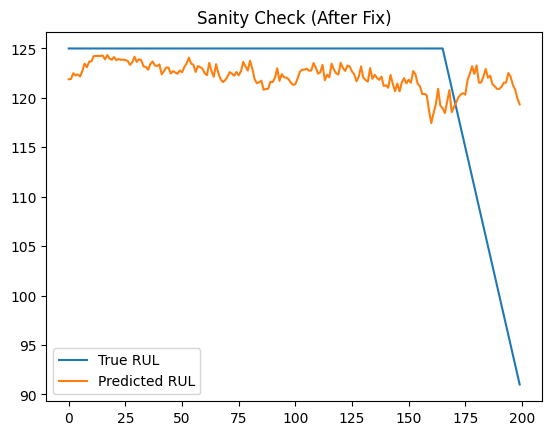

In [22]:
pred = model.predict(X_train[:200])

plt.figure()
plt.plot(y_train[:200], label='True RUL')
plt.plot(pred.flatten(), label='Predicted RUL')
plt.legend()
plt.title("Sanity Check (After Fix)")
plt.show()

In [23]:
print("Final Training MAE:", history.history['mae'][-1])
print("Final Validation MAE:", history.history['val_mae'][-1])
print("Final Training MSE:", history.history['loss'][-1])
print("Final Validation MSE:", history.history['val_loss'][-1])


Final Training MAE: 15.38532543182373
Final Validation MAE: 15.416508674621582
Final Training MSE: 436.4129943847656
Final Validation MSE: 425.122802734375


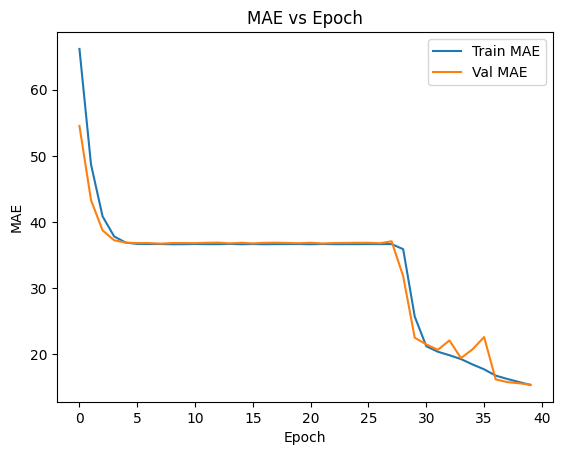

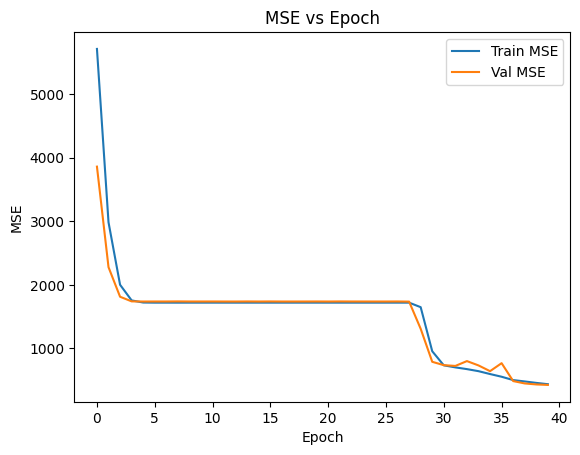

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE vs Epoch')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE vs Epoch')
plt.show()
